In [1]:
# pip install numpy
# pip install opencv-python
# pip install scikit-image
# pip install scikit-learn
# pip install matplotlib
# pip install seaborn

In [2]:
import numpy as np
import cv2
import os
import random
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Function to load images from folder, picking 1000 random images from each class
def load_images_from_folder(folder, num_images_per_class=1200):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if not os.path.isdir(class_folder):
            print(f"Skipping non-directory item: {class_folder}")
            continue
        all_images = os.listdir(class_folder)
        if len(all_images) < num_images_per_class:
            print(f"Not enough images in {class_folder}. Found {len(all_images)}, required {num_images_per_class}")
            continue
        selected_images = random.sample(all_images, num_images_per_class)
        for filename in selected_images:
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            img = cv2.resize(img, (256, 256))  # Resizing images to a consistent size 
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Loading images and labels
folder = 'D:\AAI_project\COMP-6721-Project\data' 
images, labels = load_images_from_folder(folder)
print(f"Loaded {len(images)} images with {len(labels)} labels.")
print(f"Unique labels found: {set(labels)}")

Loaded 6000 images with 6000 labels.
Unique labels found: {'bar', 'restaurant', 'hospital_room', 'gymnasium', 'subway_station'}


In [5]:
# Function to extract color histograms
def extract_color_histograms(images):
    histograms = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)
    return np.array(histograms)

In [6]:
def extract_lbp_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)


In [7]:
# Extracting color histograms
X_color_hist = extract_color_histograms(images)

# Extract LBP features
X_lbp = extract_lbp_features(images)

# Flatten images for the classifier
images_flattened = images.reshape((images.shape[0], -1))

In [8]:
# Concatenate features with flattened pixel values
X_combined = np.concatenate((images_flattened, X_color_hist, X_lbp), axis=1)

In [9]:
# Split the data into labeled and unlabeled sets
X_train,X_test, y_train, y_test= train_test_split(X_combined, labels, test_size=0.2, random_state=42, stratify=labels)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)


In [10]:
len(X_labeled)

960

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
# clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_labeled, y_labeled)

RandomForestClassifier(random_state=42)

In [12]:
# Function to process the unlabeled data in batches
def process_unlabeled_in_batches(clf, X_unlabeled, batch_size=500):
    num_samples = X_unlabeled.shape[0]
    y_unlabeled_pred = np.zeros(num_samples, dtype=str)
    probas = np.zeros((num_samples, clf.n_classes_), dtype=float)

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        X_batch = X_unlabeled[start:end]
        y_unlabeled_pred[start:end] = clf.predict(X_batch)
        probas[start:end] = clf.predict_proba(X_batch)

    return y_unlabeled_pred, probas



def process_unlabeled(clf, X_unlabeled):
    y_unlabeled_pred = clf.predict(X_unlabeled)
    probas = clf.predict_proba(X_unlabeled)
    return y_unlabeled_pred, probas


def collect_high_confidence_samples(X_unlabeled, y_unlabeled_pred, probas, prob_threshold=0.7):
    print("Collecting high-confidence samples")
    high_confidence_indices = np.where(np.max(probas, axis=1) > prob_threshold)[0]

    if len(high_confidence_indices) > 0:
        X_high_conf = X_unlabeled[high_confidence_indices]
        y_high_conf = y_unlabeled_pred[high_confidence_indices]
    else:
        X_high_conf = np.array([])
        y_high_conf = np.array([])

    return X_high_conf, y_high_conf, high_confidence_indices


# Pseudo-labeling and iterative training
for iteration in range(10):  
    # Process the unlabeled data in batches
    y_unlabeled_pred, probas = process_unlabeled(clf, X_unlabeled)
    
    # Collect high-confidence samples
    X_high_conf, y_high_conf, high_confidence_indices = collect_high_confidence_samples(X_unlabeled, y_unlabeled_pred, probas)


    if len(high_confidence_indices) == 0:
        print(f"Iteration {iteration + 1}: No high-confidence samples found. Stopping iteration.")
        break


    if X_high_conf.size == 0:
        print(f"Iteration {iteration + 1}: No samples passed the threshold. Stopping iteration.")
        break

    # Calculate and print the accuracy of the high-confidence samples
    high_confidence_accuracy = accuracy_score(y_unlabeled[high_confidence_indices], y_high_conf)
    print("\n")
    print(f"Iteration {iteration + 1}")
    print(f"High-confidence samples accuracy = {high_confidence_accuracy:.4f}")


    # Update the labeled dataset
    X_labeled = np.vstack((X_labeled, X_high_conf))
    y_labeled = np.hstack((y_labeled, y_high_conf))

    # Remove the high-confidence samples from the unlabeled set
    X_unlabeled = np.delete(X_unlabeled, high_confidence_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, high_confidence_indices, axis=0)

    # Retrain the model with the updated labeled dataset
    clf.fit(X_labeled, y_labeled)

    # Evaluate the model after retraining
    y_test_pred = clf.predict(X_test)
    train_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test data accuracy = {train_accuracy:.4f}")

    if X_unlabeled.size == 0:
        print("No more unlabeled data left.")
        break
    print("-----------------------------")



Iteration 1
High-confidence samples accuracy = 0.8413
Test data accuracy = 0.4800
-----------------------------


Iteration 2
High-confidence samples accuracy = 0.6508
Test data accuracy = 0.4592
-----------------------------


Iteration 3
High-confidence samples accuracy = 0.7111
Test data accuracy = 0.4600
-----------------------------


Iteration 4
High-confidence samples accuracy = 0.6585
Test data accuracy = 0.4792
-----------------------------


Iteration 5
High-confidence samples accuracy = 0.6585
Test data accuracy = 0.4642
-----------------------------


Iteration 6
High-confidence samples accuracy = 0.6875
Test data accuracy = 0.4550
-----------------------------


Iteration 7
High-confidence samples accuracy = 0.7879
Test data accuracy = 0.4733
-----------------------------


Iteration 8
High-confidence samples accuracy = 0.5667
Test data accuracy = 0.4533
-----------------------------


Iteration 9
High-confidence samples accuracy = 0.6364
Test data accuracy = 0.4683
----

In [13]:
# Predicting and evaluating the final Decision Tree classifier
y_pred = clf.predict(X_unlabeled)
accuracy = accuracy_score(y_unlabeled, y_pred)
precision = precision_score(y_unlabeled, y_pred, average='weighted')
recall = recall_score(y_unlabeled, y_pred, average='weighted')
f1 = f1_score(y_unlabeled, y_pred, average='weighted')

In [14]:
# Classification report and metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_unlabeled, y_pred))


Accuracy: 42.15%
Precision: 40.85%
Recall: 42.15%
F1 Score: 40.25%

Classification Report:
                 precision    recall  f1-score   support

           bar       0.41      0.54      0.47       624
     gymnasium       0.47      0.55      0.51       713
 hospital_room       0.42      0.58      0.49       660
    restaurant       0.32      0.16      0.21       708
subway_station       0.41      0.30      0.35       726

      accuracy                           0.42      3431
     macro avg       0.41      0.43      0.41      3431
  weighted avg       0.41      0.42      0.40      3431



In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_unlabeled, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[339  54  54  85  92]
 [ 40 394 162  48  69]
 [ 41 139 386  39  55]
 [225 125 156 110  92]
 [173 121 152  63 217]]


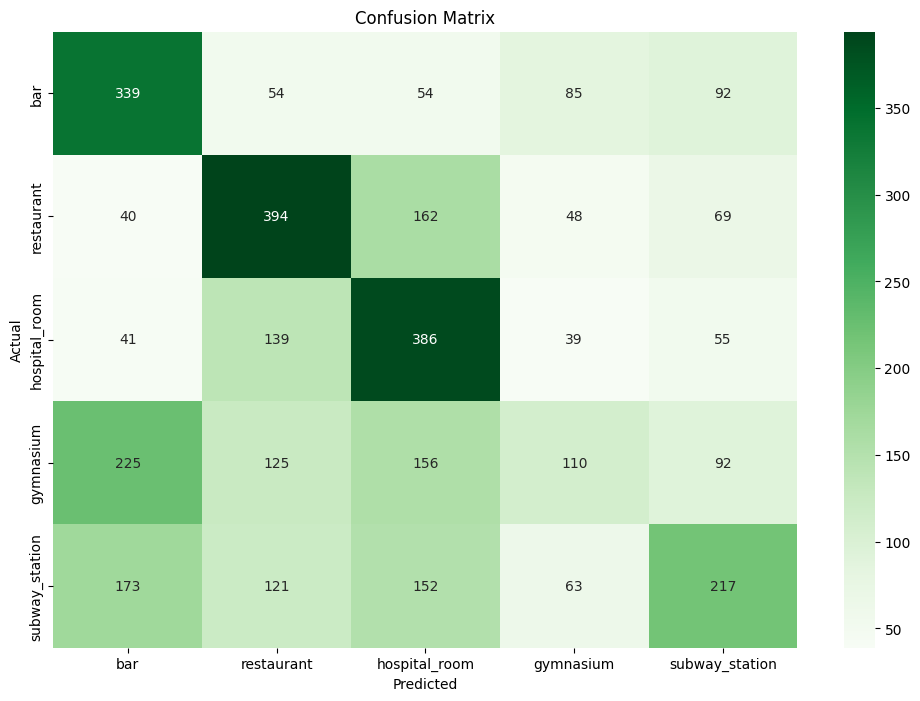

In [16]:
# Plotting the Confusion Matrix for our Decision Tree Model
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=set(labels), yticklabels=set(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Saving the semi-supervised decision tree model
model_path = 'D:\AAI_project\COMP-6721-Project\src\semi_supervised_decision_tree_model.joblib' 
joblib.dump(clf, model_path)
print(f'Model saved to {model_path}')

Model saved to D:\AAI_project\COMP-6721-Project\src\semi_supervised_decision_tree_model.joblib
